# Introduction

In this phase, the goal is to train several classification models and test their performance against our dataset. Then, after having the results using a set of evaluation metrics we will choose the best classifier. This whole process starts with the splitting of our initial dataset into three sets (Training, Test, and Validation), following the criteria we discussed at the Exploratory Data Analysis, and then apply the pre-processing step: the transformation and selection of features (over the Training and Test datasets) and also applying SMOTE to mitigate the effect of the imbalance of the classes.

In [1]:
# Import modules

import pandas as pd
import numpy as np

from time import time

#Ignore warnings
import warnings

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as PathEffects
import plotly.graph_objects as go

from matplotlib import offsetbox

# Pre-processing
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Evaluation metrics
import sklearn.metrics
from sklearn.metrics import auc,\
                            classification_report,\
                            precision_score,\
                            recall_score,\
                            accuracy_score,\
                            fbeta_score,\
                            roc_curve,\
                            roc_auc_score,\
                            ConfusionMatrixDisplay,\
                            plot_roc_curve,\
                            plot_confusion_matrix,\
                            balanced_accuracy_score


# Clssification models
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

#  Feature importance
from yellowbrick.datasets import load_occupancy
from yellowbrick.model_selection import FeatureImportances

# K-fold corss validation
from sklearn.model_selection import KFold, cross_validate, cross_val_score
from sklearn.metrics import fbeta_score, make_scorer

pd.options.mode.chained_assignment = None  # default='warn'

# Yellowbrick
from yellowbrick.classifier import PrecisionRecallCurve,\
                                   classification_report,\
                                   confusion_matrix,\
                                   roc_auc,\
                                   precision_recall_curve,\
                                   class_prediction_error,\
                                   discrimination_threshold

In [2]:
# Import Git dataset

data_path = './datasets'
df_git = pd.read_json('{}/df_git.json'.format(data_path), orient='records', lines=True)

# Separate target variable
y_git = df_git.pop('author_bot')

## Re-generate "Train", "Test" and "Validation" data sub-sets

# Divide the Dataset into 60% training and 40% test + validation
X_train_git_og, X_test_tmp_git,\
y_train_git, y_test_tmp_git = train_test_split(df_git, y_git, test_size=0.4,
                                               random_state=22, stratify=y_git)

# From 40% of the original dataset, 25% is for test and 15% is for validation
# This means we have to split the test+validation set in a 62,5%/37,5% ratio

X_test_git_og, X_val_git_og,\
y_test_git, y_val_git = train_test_split(X_test_tmp_git, y_test_tmp_git,
                                         test_size=0.375, random_state=22,
                                         stratify=y_test_tmp_git)

## Apply pre-processing to the training and test datasets

After performing the Exploratory Data Analysis, we have a clear process to consider which transformation apply to the variables and which are the ones we are selecting. 

In [3]:
def log10(x):
    return np.log(x)

def shifted_log10(x):
    return np.log(1 + x)

heuristic_terms = ['auto', 'bot', 'build', 'cd', 'ci', 'code', 'commit', 'copy',
                   'dependency', 'fix', 'integration', 'issue', 'merge', 'patrol',
                   'pr', 'pull', 'release', 'request', 'review', 'sync', 'template',
                   'tool', 'travis']

terms_l1 = ['bot', 'dependency', 'fix', 'merge', 'integration']
terms_l2 = ['build', 'travis', 'copy', 'template', 'sync',  'auto',
            'release', 'review', 'tool', 'issue', 'request', 'commit']
terms_l3 = ['ci', 'cd', 'pr', 'code', 'patrol', 'pull']

def compute_terms_score(x, terms):
    score = 0
    n_l1 = 0
    n_l2 = 0
    n_l3 = 0
    for term in terms:
        if term.lower() in x.lower():
            if term in terms_l1:
                n_l1 += 1
            elif term in terms_l2:
                n_l2 += 1
            elif term in terms_l3:
                n_l3 += 1
    score = 60*n_l1 + 30*n_l2 + 10*n_l3

    return score

def preprocess_git_df(git_df):
    new_git_df = pd.DataFrame()
    new_git_df["git__log_num_commits"] = git_df["git__num_commits"].apply(lambda x: log10(x))
    new_git_df["git__log_num_merge_commits"] = git_df["git__num_merge_commits"].apply(lambda x: shifted_log10(x))
    new_git_df["git__log_num_weekend_commits"] = git_df["git__num_weekend_commits"].apply(lambda x: shifted_log10(x))
    new_git_df["git__log_num_signed_commits"] = git_df["git__num_signed_commits"].apply(lambda x: shifted_log10(x))
    
    new_git_df["git__log_num_repos"] = git_df["git__num_repos"].apply(lambda x: log10(x))
    new_git_df["git__log_median_files"] = git_df["git__median_files"].apply(lambda x: shifted_log10(x))
    new_git_df["git__log_iqr_files"] = git_df["git__iqr_files"].apply(lambda x: shifted_log10(x))
    
    new_git_df["git__log_median_lines_added"] = git_df["git__median_lines_added"].apply(lambda x: shifted_log10(x))
    new_git_df["git__log_median_lines_removed"] = git_df["git__median_lines_removed"].apply(lambda x: shifted_log10(x))
    new_git_df["git__log_median_len_commit_message"] = git_df["git__median_len_commit_message"].apply(lambda x: shifted_log10(x))
    new_git_df["git__log_iqr_len_words_commit_message"] = git_df["git__iqr_len_words_commit_message"].apply(lambda x: shifted_log10(x))
    
    new_git_df['terms_score'] = git_df['author_name'].apply(lambda x: compute_terms_score(x, heuristic_terms))
    
    return new_git_df

X_train_git = preprocess_git_df(X_train_git_og)
X_test_git = preprocess_git_df(X_test_git_og)
X_train_git.head()

,git__log_num_commits,git__log_num_merge_commits,git__log_num_weekend_commits,git__log_num_signed_commits,git__log_num_repos,git__log_median_files,git__log_iqr_files,git__log_median_lines_added,git__log_median_lines_removed,git__log_median_len_commit_message,git__log_iqr_len_words_commit_message,terms_score
2352,7.080868,2.302585,5.986452,0.0,5.087596,0.693147,1.098612,1.791759,1.098612,5.129899,2.564949,0
2985,6.453625,5.497168,5.442418,0.0,0.000000,0.693147,0.693147,0.693147,0.000000,4.158883,2.197225,0
390,2.772589,0.000000,1.098612,0.0,1.791759,0.693147,0.810930,1.504077,1.098612,5.117994,2.197225,0
1164,3.737670,1.098612,1.945910,0.0,0.693147,0.693147,0.000000,1.098612,0.693147,3.891820,2.014903,0
2935,2.484907,0.000000,0.000000,0.0,0.693147,1.386294,0.916291,3.465736,0.693147,5.249652,2.442347,0


### Apply SMOTE to mitigate the effect of imbalanced data

We already commented in the Exploratory Data Analysis the fact that one of the main challenges of this project is the imbalance in the target class we are aiming to detect. This context was taken into account when splitting the main dataset into the training, test, and validation tests, but it needs another processing stage before they feed the different classification models.

**SMOTE** is based on an algorithm generating new samples considering the k-nearest neighbors from each original sample from the **training set**. Each newly generated sample is interpolated between the original sample and one of the nearest neighbors; with a random component $\lambda$, which takes value in the range $[0, 1]$.

In [4]:
smt = SMOTE(random_state=22)
X_train_git_SMOTE, y_train_git_SMOTE = smt.fit_resample(X_train_git, y_train_git)

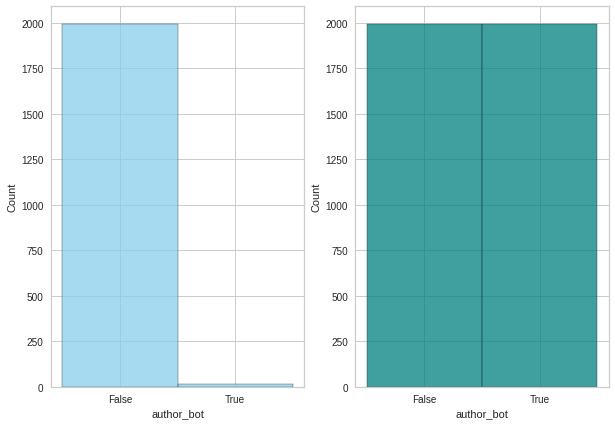

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10,7))

sns.histplot(data=y_train_git.replace({0: 'False', 1: 'True'}), stat='count', kde=False, color="skyblue", ax=axs[0])
sns.histplot(data=y_train_git_SMOTE.replace({0: 'False', 1: 'True'}), stat='count', kde=False, discrete=True, color="teal", ax=axs[1])

plt.show()

### PCA

We applied PCA (Principal Component Analysis} to discover if there was a combination of features that would suit as input for the classification model, but we discarded it as the results indicated that one component accumulated most of the percentage of variance explained.

In [6]:
pca = PCA(n_components=3, random_state=22)
principalComponents = pca.fit_transform(X_train_git_SMOTE)
trainDf = pd.DataFrame(data=principalComponents)

variance_ratio = list(pca.explained_variance_ratio_)
count = 0 # in case list is empty
for count, var in enumerate(variance_ratio, start=1):
    print('Var. {}: \tExplained Variance ratio: {}'.format(count,
                                                           round(var, 3)))

Var. 1: 	Explained Variance ratio: 0.983
Var. 2: 	Explained Variance ratio: 0.011
Var. 3: 	Explained Variance ratio: 0.002


## Study classes' distribution using t-SNE

Here, the objective is to show how the samples from the Training set were distributed using the t-SNE algorithm, a nonlinear dimensionality reduction technique. This way we could convert our high-dimensional dataset into a two-dimensional one, preserving the distance between the samples in the new dimensional space. The following figures show the redimensioned Training dataset before and applying SMOTE, respectively: In the first image, we can observe very few occurrences of positive Bot accounts, and heavily mixed among the rest of the samples from the other class; while in the second image we can observe a much clearer distinction between the two classes, after the synthetic samples generated by SMOTE. Apart from the interesting pattern these samples are forming, we infer that there should be a classification model capable of separating both classes.

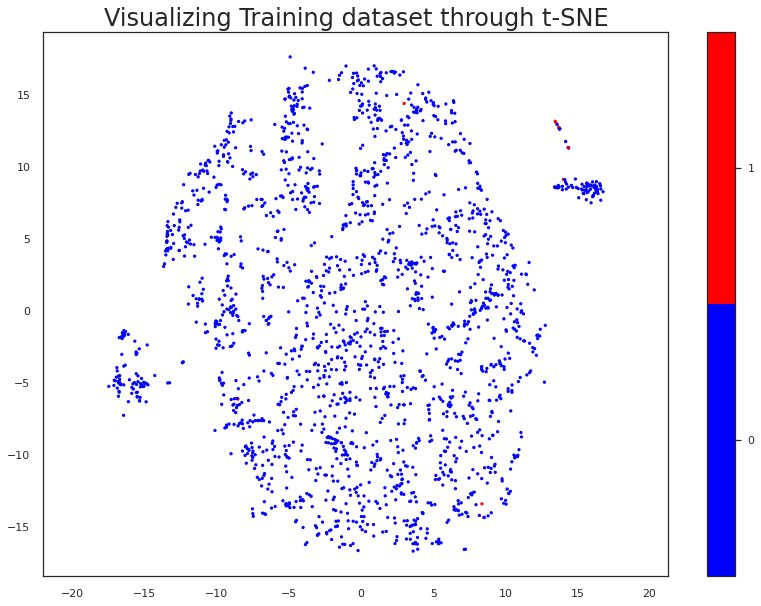

In [7]:
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

warnings.filterwarnings('ignore')

tsne = TSNE(random_state = 22, n_components=2,verbose=0, perplexity=40, n_iter=300).fit_transform(X_train_git)
plt.scatter(tsne[:, 0], tsne[:, 1], s=5, c=y_train_git, cmap='bwr')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))
plt.title('Visualizing Training dataset through t-SNE', fontsize=24);

# plt.savefig('data-tsne.png', dpi=600, transparent=True)

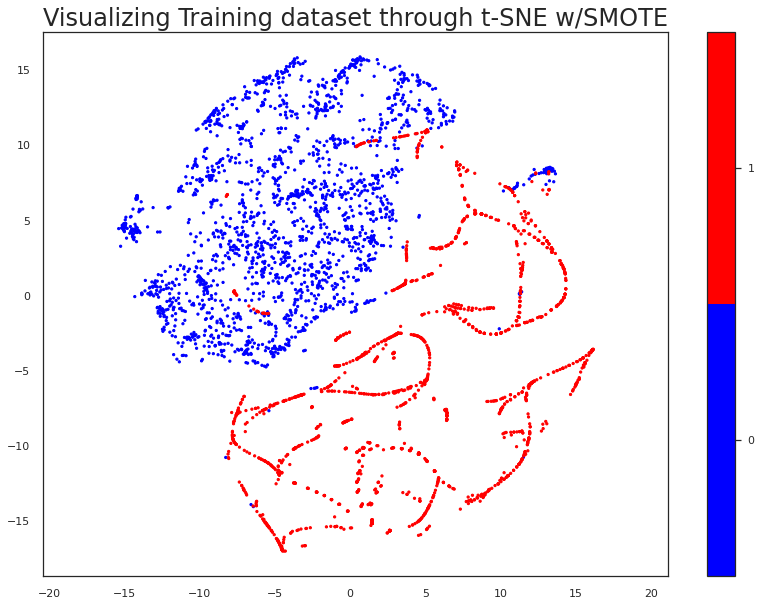

In [8]:
standardized_data_SMOTE = StandardScaler().fit_transform(X_train_git_SMOTE)

tsne_SMOTE = TSNE(random_state = 22, n_components=2,verbose=0, perplexity=40, n_iter=300).fit_transform(X_train_git_SMOTE)

plt.scatter(tsne_SMOTE[:, 0], tsne_SMOTE[:, 1], s= 5, c=y_train_git_SMOTE, cmap='bwr')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))
plt.title('Visualizing Training dataset through t-SNE w/SMOTE', fontsize=24);

# plt.savefig('data-tsne-smote.png', dpi=600, transparent=True)

## Evaluation metrics

We need to use a set of metrics that help us to evaluate the performance of the different classification models. The main method to compare the results from the different models is a **confusion matrix**, which displays the number of elements that have and have not been identified correctly.

Looking at the possible values we can obtain, it is worth mentioning that not all the misclassified cases affect our use case in the same way: having **False Negatives** is worse than having **False Positives**. This means it is more important to classify as many bot accounts as possible (and not mistake any of them for a human) rather than classifying a human as a bot when it is not the case. In the first case, missing a bot account among the plethora of contributors in a community could mean that potentially this bot account remains hidden (and hardly going to be identified); while in the latter, this wrong recommendation could be just ignored.

This links directly to the definition of two basic metrics: **precision** and **recall**. As it is defined in [Scikit-learn's documentation page](https://scikit-learn.org/stable/modules/model_evaluation.html\#precision-recall-f-measure-metrics), an intuitive definition of precision is the ability of the classifier not to label as positive a sample that is negative, and recall is the ability of the classifier to find all the positive samples.

Although it is common to use the **F1-score** as an evaluation metric for classification models, this score is considering that the recall and the precision are equally important. This is why the decision was to use a **F-beta** score with $\beta = 2$, to penalize those classification models with a greater number of **False  Negatives**.

In [9]:
def print_model_report(model, X_train, y_train, X_test, y_test):

    model_name = type(model).__name__
    
    plt.figure(figsize=(5,5))
    confusion_matrix(model, X_train, y_train, X_test, y_test)

    y_pred = model.predict(X_test)
    f2_score = round(fbeta_score(y_test, y_pred, beta=2), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)
    
    return precision, recall, f2_score


def add_score_to_df(scores_dataframe, model_name, model_subset, results):
    precision = results[0]
    recall = results[1]
    f2_score = results[2]
    new_row = pd.Series({'model_subset': model_subset,
                         'model_name': model_name,
                         'precision_score': round(precision, 3),
                         'recall_score': round(recall, 3),
                         'f2_score': round(f2_score, 3)})
    return pd.concat([df_scores, new_row.to_frame().T], ignore_index=True)


# Initialize DF including all scores
df_scores = pd.DataFrame()

## Testing the classification models

The proposed classifiers were trained and then tested, adjusting the specific hyper-parameters for each model until finding the best scoring for each of them. 

### Gaussian Naïve-Bayes

**Naïve-Bayes** supervised-learning algorithms are based on Bayes’ theorem. They belong to the Probability-based learning family, and their approach is to use estimations of likelihoods to determine the most likely predictions that should be made and review them later, based on the available data and also extra evidence whenever it becomes available.

*Naïve-Bayes* classifiers are especially useful for problems with many input variables, categorical input variables with a vast number of possible values, and text classification. Among the advantages of using these classification models are their simplicity to apply (generally, no parameters to be adjusted) and their resistance to over-fitting.

The selected classifier was the **Gaussian Naïve-Bayes** algorithm

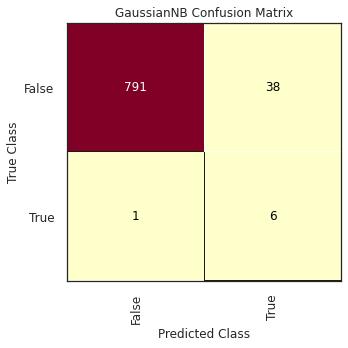

,Score
F2-score,0.417
Precision,0.136
Recall,0.857


In [10]:
# Gaussian Naive-Bayes

gnb = GaussianNB().fit(X_train_git_SMOTE, y_train_git_SMOTE)
y_pred_gnb = gnb.predict(X_test_git)

precision, recall, f2_score = print_model_report(gnb, X_train_git_SMOTE, y_train_git_SMOTE, X_test_git, y_test_git)
results = [precision, recall, f2_score]
df_scores = add_score_to_df(df_scores, 'Gaussian Naive-Bayes', 'Test', results)

# Show prettified results
score_dict = {'Score':{'Precision': precision,
                       'Recall': recall,
                       'F2-score': f2_score}}
pd.DataFrame.from_dict(score_dict)

#### Precision-Recall Curve

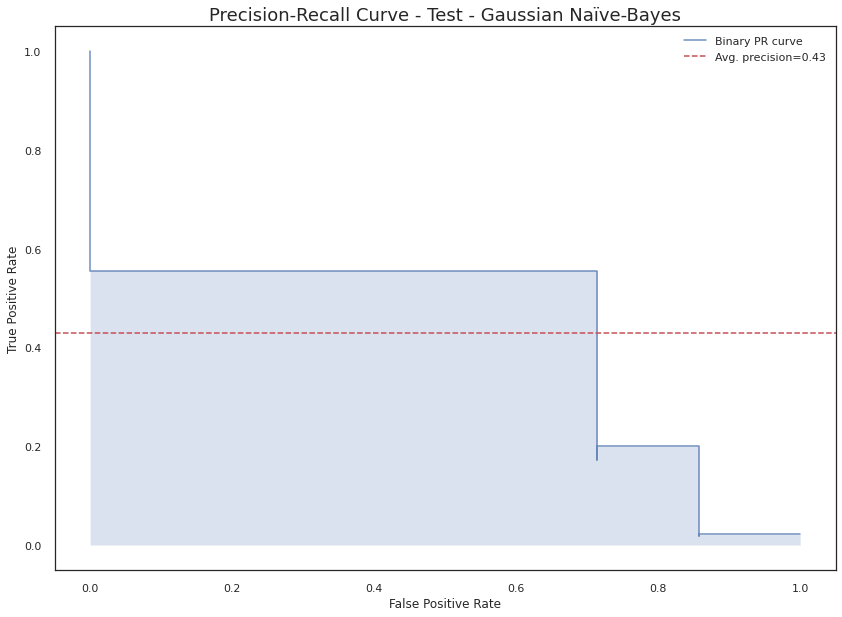

In [11]:
plt.figure()
plt.title("Precision-Recall Curve - Test - Gaussian Naïve-Bayes", fontsize=18)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)

visualizer = PrecisionRecallCurve(gnb, classes=["Human", "Bot"])
visualizer.fit(X_train_git_SMOTE, y_train_git_SMOTE)
visualizer.score(X_test_git, y_test_git)

plt.legend();

### Support Vector Classifier

The **support vector classifier** is based on the possibility of constructing a hyperplane that separates the hyperplane training observations perfectly according to their class labels. Once this hyperplane exists, the ideal scenario is that a test observation is assigned to a class depending on which side of the hyperplane it is located.

Nonetheless, observations that belong to two classes are not necessarily separable by a hyperplane. In fact, even if a separating hyper- plane does exist, then there are instances in which a classifier based on
a separating hyperplane might not be desirable. A classifier based on a separating hyperplane will necessarily perfectly classify all of the training observations; this can lead to sensitivity to individual observations and implies that it may have overfit the training data.

The support vector classifier does exactly this. Rather than seeking the largest possible margin so that
every observation is not only on the correct side of the hyperplane but also on the correct side of the margin, we instead allow some observations to be on the incorrect side of the margin, or even the incorrect side of the hyperplane.

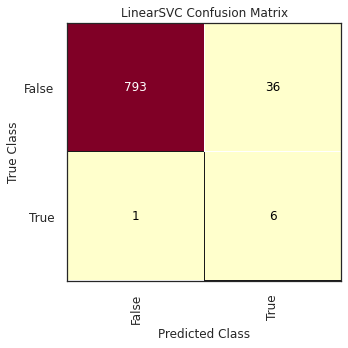

,Score
F2-score,0.429
Precision,0.143
Recall,0.857


In [12]:
# SVC

lsvc = LinearSVC(random_state=22)

lsvc.fit(X_train_git_SMOTE, y_train_git_SMOTE)

y_pred_lsvc = lsvc.predict(X_test_git)

precision, recall, f2_score =  print_model_report(lsvc, X_train_git_SMOTE, y_train_git_SMOTE, X_test_git, y_test_git)
results = [precision, recall, f2_score]
df_scores = add_score_to_df(df_scores, 'LinearSVC', 'Test', results)

# Show prettified results
score_dict = {'Score':{'Precision': precision,
                       'Recall': recall,
                       'F2-score': f2_score}}
pd.DataFrame.from_dict(score_dict)

#### Precision-Recall Curve

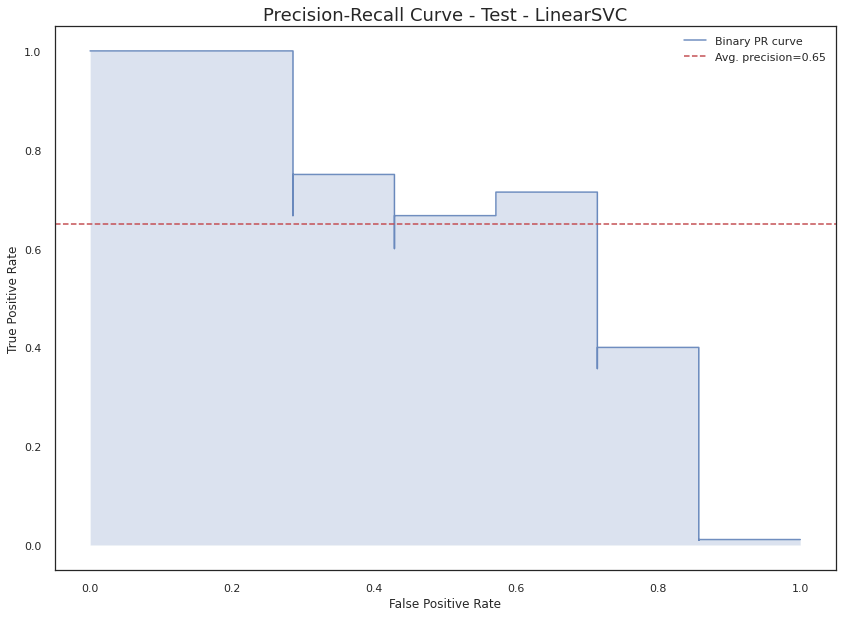

In [13]:
plt.figure()
plt.title("Precision-Recall Curve - Test - LinearSVC", fontsize=18)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)

visualizer = PrecisionRecallCurve(lsvc, classes=["Human", "Bot"])
visualizer.fit(X_train_git_SMOTE, y_train_git_SMOTE)
visualizer.score(X_test_git, y_test_git)

plt.legend();

### K-Nearest Neighbors

**K-Nearest Neighbors** is a similarity-based classification model whose main idea is to compute the classification from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest "k" (integer number) neighbors of the point.

Note that this algorithm uses the whole training dataset for making the predictions, and aside from other classification models, there are no specific assumptions that should be made concerning the data. One of the main setbacks is the fact that this algorithm is affected by noise, which implies this parameter "k" needs to be selected carefully, particularly when working with imbalanced datasets.

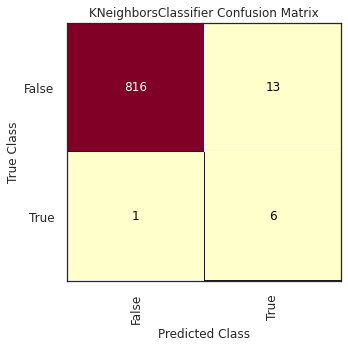

,Score
F2-score,0.638
Precision,0.316
Recall,0.857


In [14]:
# Knn

knn = KNeighborsClassifier(n_neighbors=115)
knn.fit(X_train_git_SMOTE, y_train_git_SMOTE)

y_pred_knn = knn.predict(X_test_git)

precision, recall, f2_score = print_model_report(knn, X_train_git_SMOTE, y_train_git_SMOTE, X_test_git, y_test_git)
results = [precision, recall, f2_score]
df_scores = add_score_to_df(df_scores, 'KNN', 'Test', results)

# Show prettified results
score_dict = {'Score':{'Precision': precision,
                       'Recall': recall,
                       'F2-score': f2_score}}
pd.DataFrame.from_dict(score_dict)

#### Precision-Recall Curve

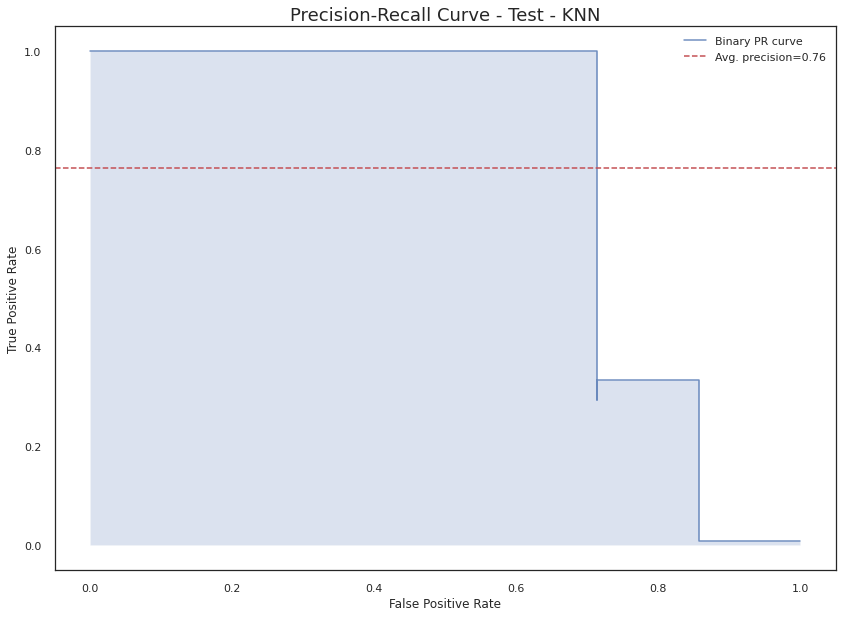

In [15]:
plt.figure()
plt.title("Precision-Recall Curve - Test - KNN", fontsize=18)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)

visualizer = PrecisionRecallCurve(knn, classes=["Human", "Bot"])
visualizer.fit(X_train_git_SMOTE, y_train_git_SMOTE)
visualizer.score(X_test_git, y_test_git)

plt.legend();

### Decision Trees

The **Decision Trees** (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a set of if-else decision rules.

Providing a more academic definition, a classification tree predicts that each observation belongs to the most commonly occurring class of training observations in the region to which it belongs. In interpreting the results of a classification tree, we are often interested not only in the class prediction corresponding to a particular terminal node region, but also in the class proportions among the training observations that fall into that region.

We use recursive binary splitting to grow a classification tree. Since we plan to assign an observation in a given region to the most commonly occurring class of training observations in that region, the classification  rror rate is simply the fraction of the training observations in that region that do not belong to the most common class. When building a classification tree, either the Gini index or the entropy is typically used to evaluate the quality of a particular split, since these two approaches are more sensitive to node purity than 
the classification error rate. Any of these three approaches might be used when pruning the tree, but the classification error rate is preferable if the prediction accuracy of the final pruned tree is the goal.

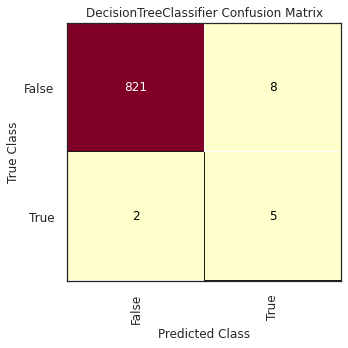

,Score
F2-score,0.610
Precision,0.385
Recall,0.714


In [16]:
# criterion='gini'

dt = DecisionTreeClassifier(random_state=22, max_depth=5)
dt.fit(X_train_git_SMOTE, y_train_git_SMOTE)

y_pred_dt = dt.predict(X_test_git)

precision, recall, f2_score = print_model_report(dt, X_train_git_SMOTE, y_train_git_SMOTE, X_test_git, y_test_git)
results = [precision, recall, f2_score]
df_scores = add_score_to_df(df_scores, 'Decision Tree', 'Test', results)

# Show prettified results
score_dict = {'Score':{'Precision': precision,
                       'Recall': recall,
                       'F2-score': f2_score}}
pd.DataFrame.from_dict(score_dict)

#### Precision-Recall Curve

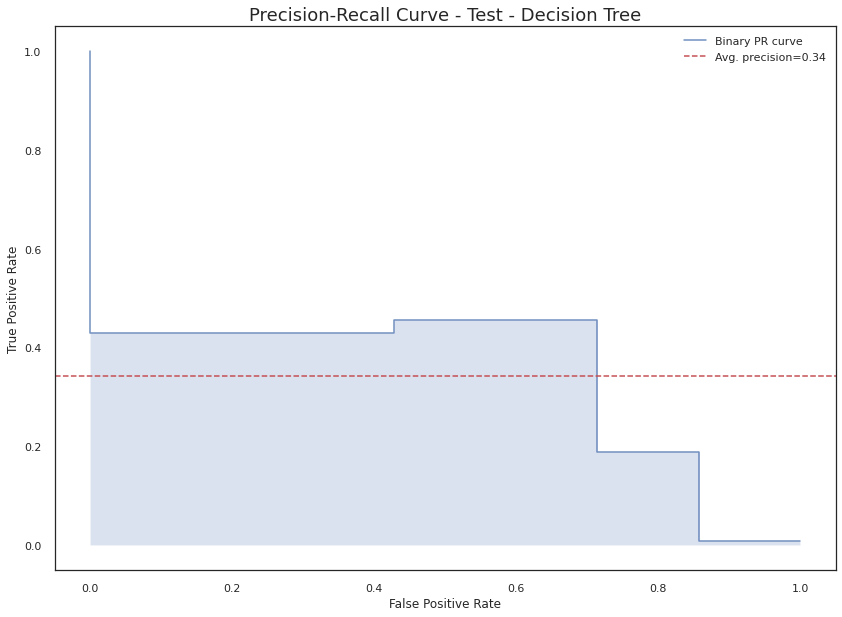

In [17]:
plt.figure()
plt.title("Precision-Recall Curve - Test - Decision Tree", fontsize=18)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)

visualizer = PrecisionRecallCurve(dt, classes=["Human", "Bot"])
visualizer.fit(X_train_git_SMOTE, y_train_git_SMOTE)
visualizer.score(X_test_git, y_test_git)

plt.legend();

#### Represent decision tree

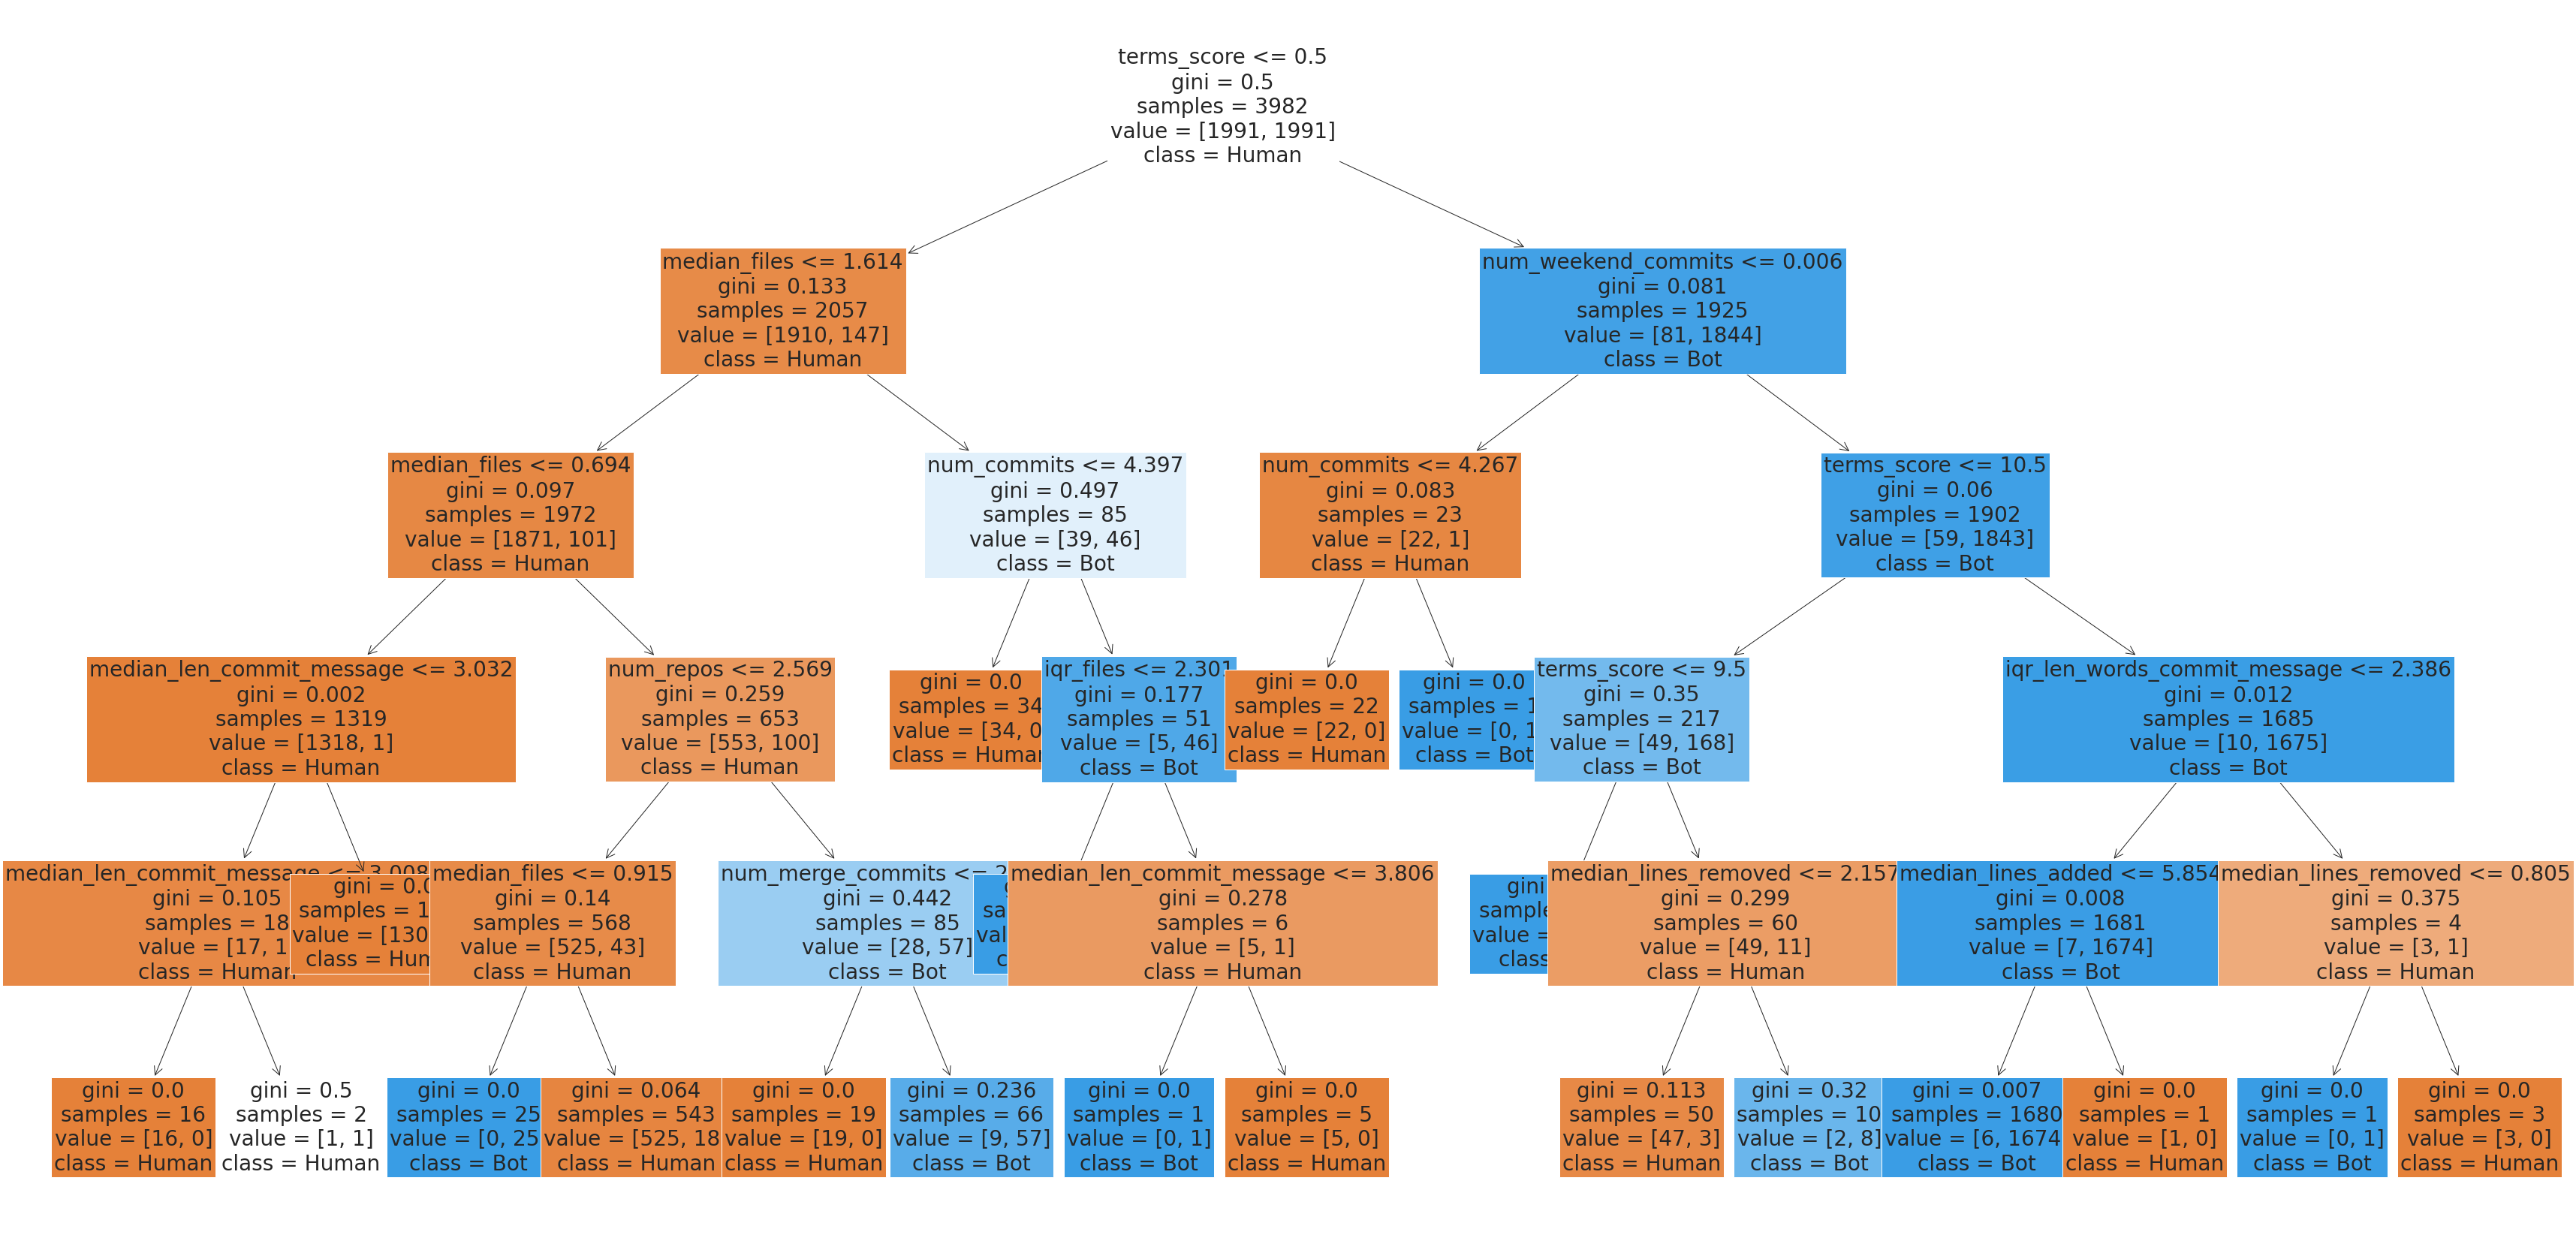

In [18]:
def shorten_name(col_name):
    if 'git__log_' in col_name:
        col_name = col_name.replace('git__log_', '')
    return col_name

list_cols = list(X_train_git_SMOTE.columns)
list_cols = [shorten_name(var_name) for var_name in list_cols]
list_cols

plt.figure(figsize=(60,30))
tree.plot_tree(dt, feature_names=list_cols,  
                   class_names=['Human', 'Bot'],
                   filled=True, fontsize=28)
plt.show()

### Random forest

We have tested the Decision Trees algorithm. Let's have a lookt at some of its pros and cons.

Some of the main advantages of this algorithm are:

* It is simple to understand and interpret. Trees can be visualized: if a given situation is observable, the explanation for the condition is easily explained by boolean logic.
* Requires little data preparation. Other techniques often require data normalization, dummy variables need to be created and blank values to be removed.
* Performs well even if its assumptions are somewhat violated by the true model from which the data were generated.

The most remarkable disadvantages are:

* DTs can create over-complex trees that do not generalize the data well (over-fitting).
* They can be unstable because small variations in the data might result in a completely different tree being generated.
* Decision-tree learners create biased trees if some classes dominate. In our case, this effect would be mitigated because we applied SMOTE to balance both classes.


Regarding the two first disadvantages, both can be addressed by using an ensemble model taking many decision trees. This is where the **Random Forest (RF) classifier** comes into play: it builds a number of decision trees on bootstrapped training samples. When building these decision trees, each time a split in a tree is considered, a random sample of $m$ predictors is chosen as split candidates from the full set of $p$ predictors. The split is allowed to use only one of those $m$ predictors. A fresh sample of $\sqrt{m}$ predictors is taken at each split, and typically we choose $m \approx p$—that is, the number of predictors considered at each split is approximately equal to the square root of the total number of predictors.

Then, the prediction of the ensemble is computed as the averaged prediction of these individual 
classifiers, improving the predictive accuracy and preventing over-fitting.

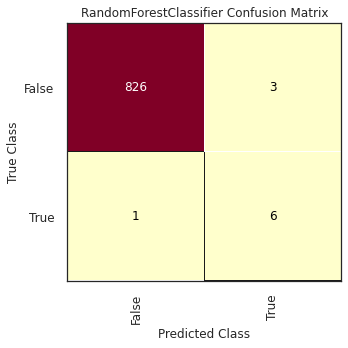

,Score
F2-score,0.811
Precision,0.667
Recall,0.857


In [19]:
# Random forest: hyperparameters

rf_adj = RandomForestClassifier(n_estimators=300, criterion='gini', random_state=22, max_depth=4)
rf_adj.fit(X_train_git_SMOTE, y_train_git_SMOTE)

y_pred_rf_adj = rf_adj.predict(X_test_git)

precision, recall, f2_score = print_model_report(rf_adj, X_train_git_SMOTE, y_train_git_SMOTE, X_test_git, y_test_git)
results = [precision, recall, f2_score]
df_scores = add_score_to_df(df_scores, 'Random Forest', 'Test', results)

# Show prettified results
score_dict = {'Score':{'Precision': precision,
                       'Recall': recall,
                       'F2-score': f2_score}}
pd.DataFrame.from_dict(score_dict)

#### Precision-Recall Curve

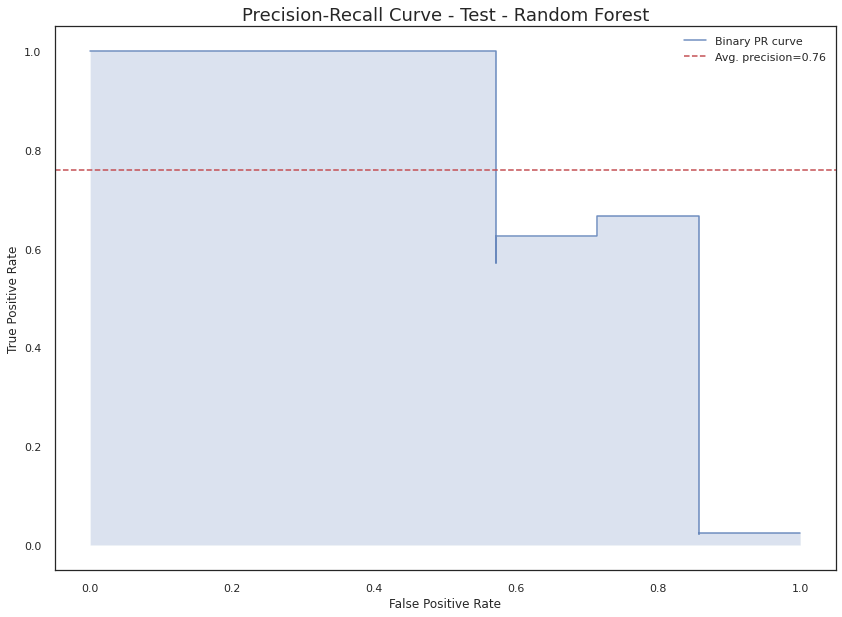

In [20]:
plt.figure()
plt.title("Precision-Recall Curve - Test - Random Forest", fontsize=18)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)

visualizer = PrecisionRecallCurve(rf_adj, classes=["Human", "Bot"])
visualizer.fit(X_train_git_SMOTE, y_train_git_SMOTE)
visualizer.score(X_test_git, y_test_git)

plt.legend();

#### Feature importance

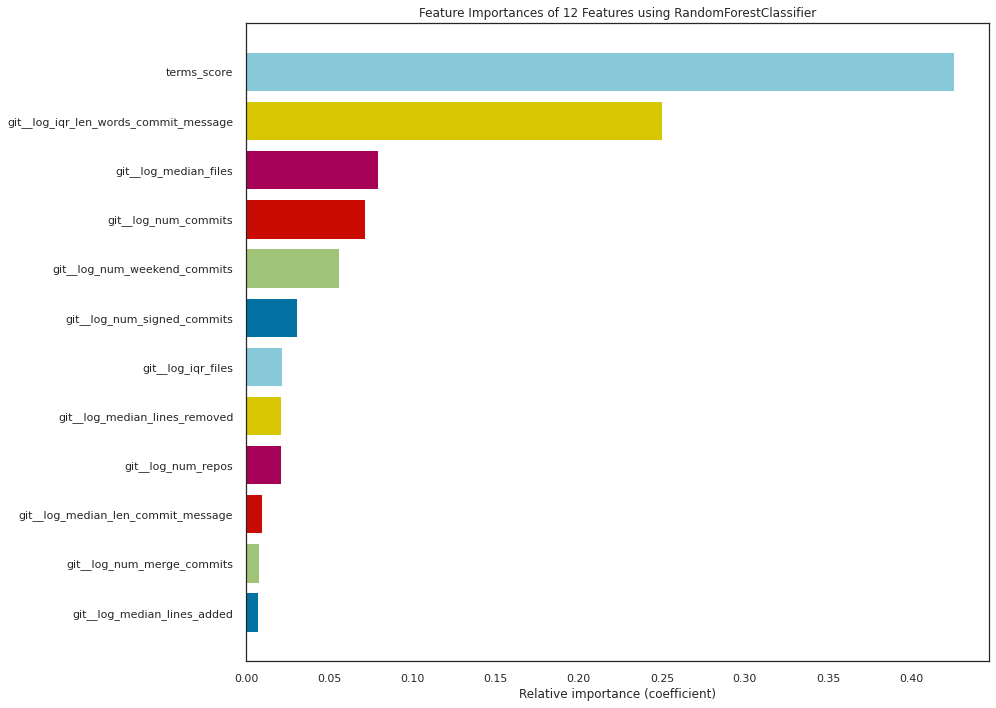

In [21]:
viz = FeatureImportances(rf_adj, xlabel='Relative importance (coefficient)', relative=False, colormap='yellowbrick')
viz.fit(X_test_git, y_test_git)
viz.show();

#### Plot some trees composing the random forest

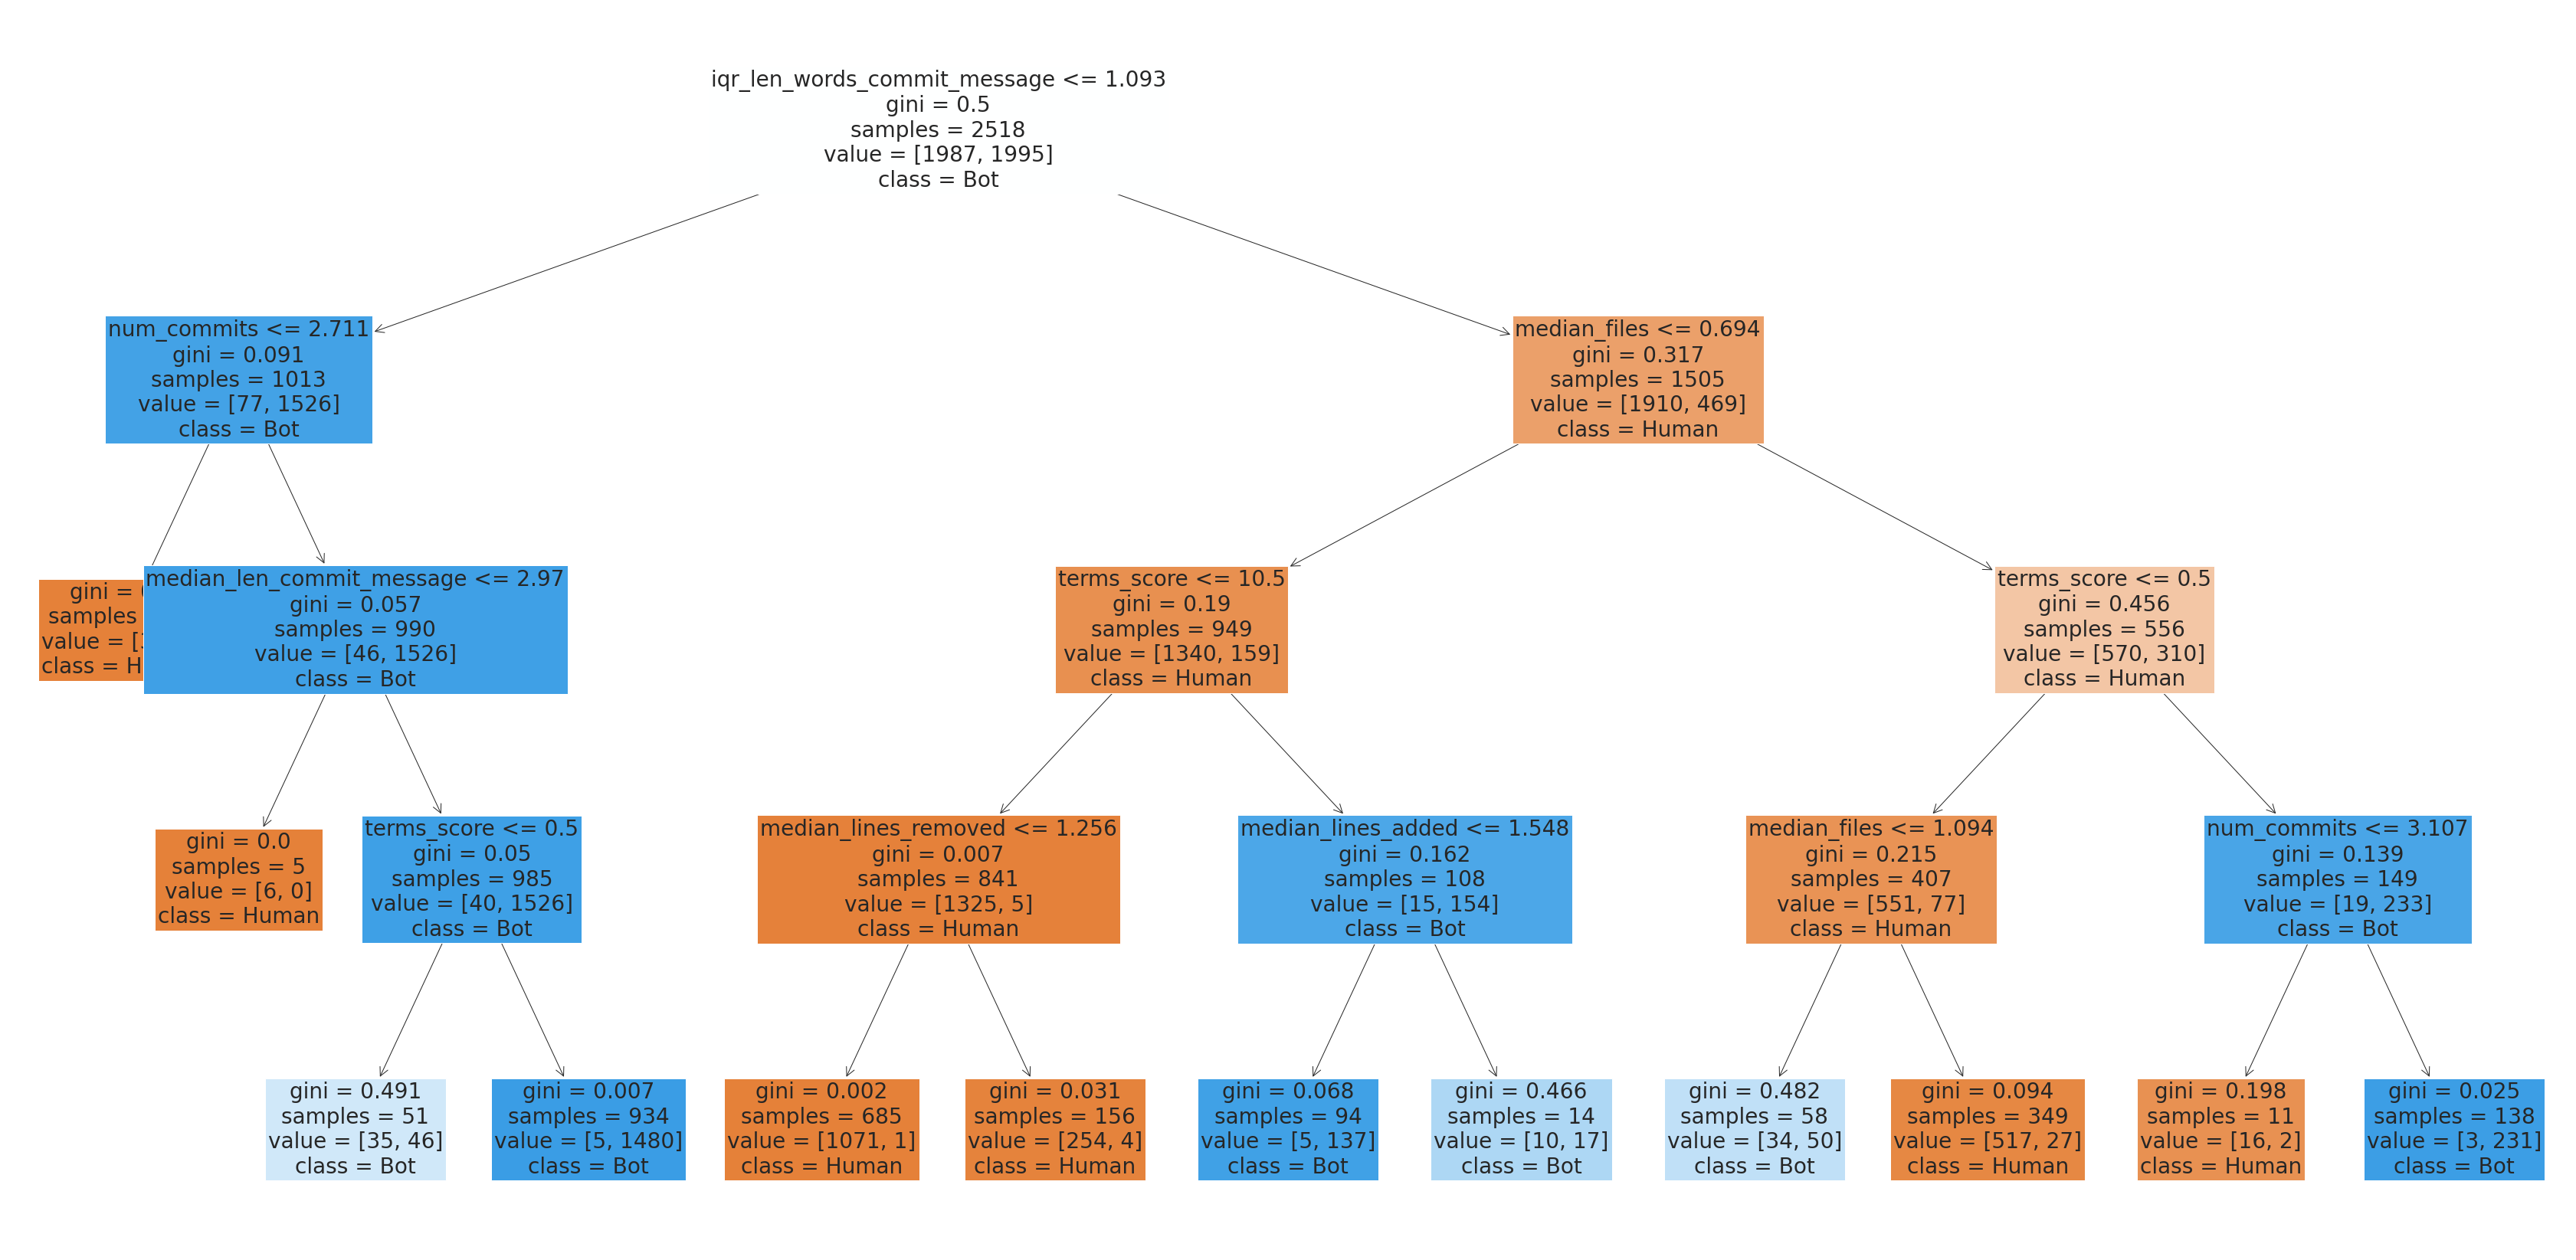

In [22]:
# Plot a couple of the trees composing the random forest

plt.figure(figsize=(60,30))
tree.plot_tree(rf_adj[22], feature_names=list_cols,  
               class_names=['Human', 'Bot'],
               filled=True, fontsize=28)
plt.show()

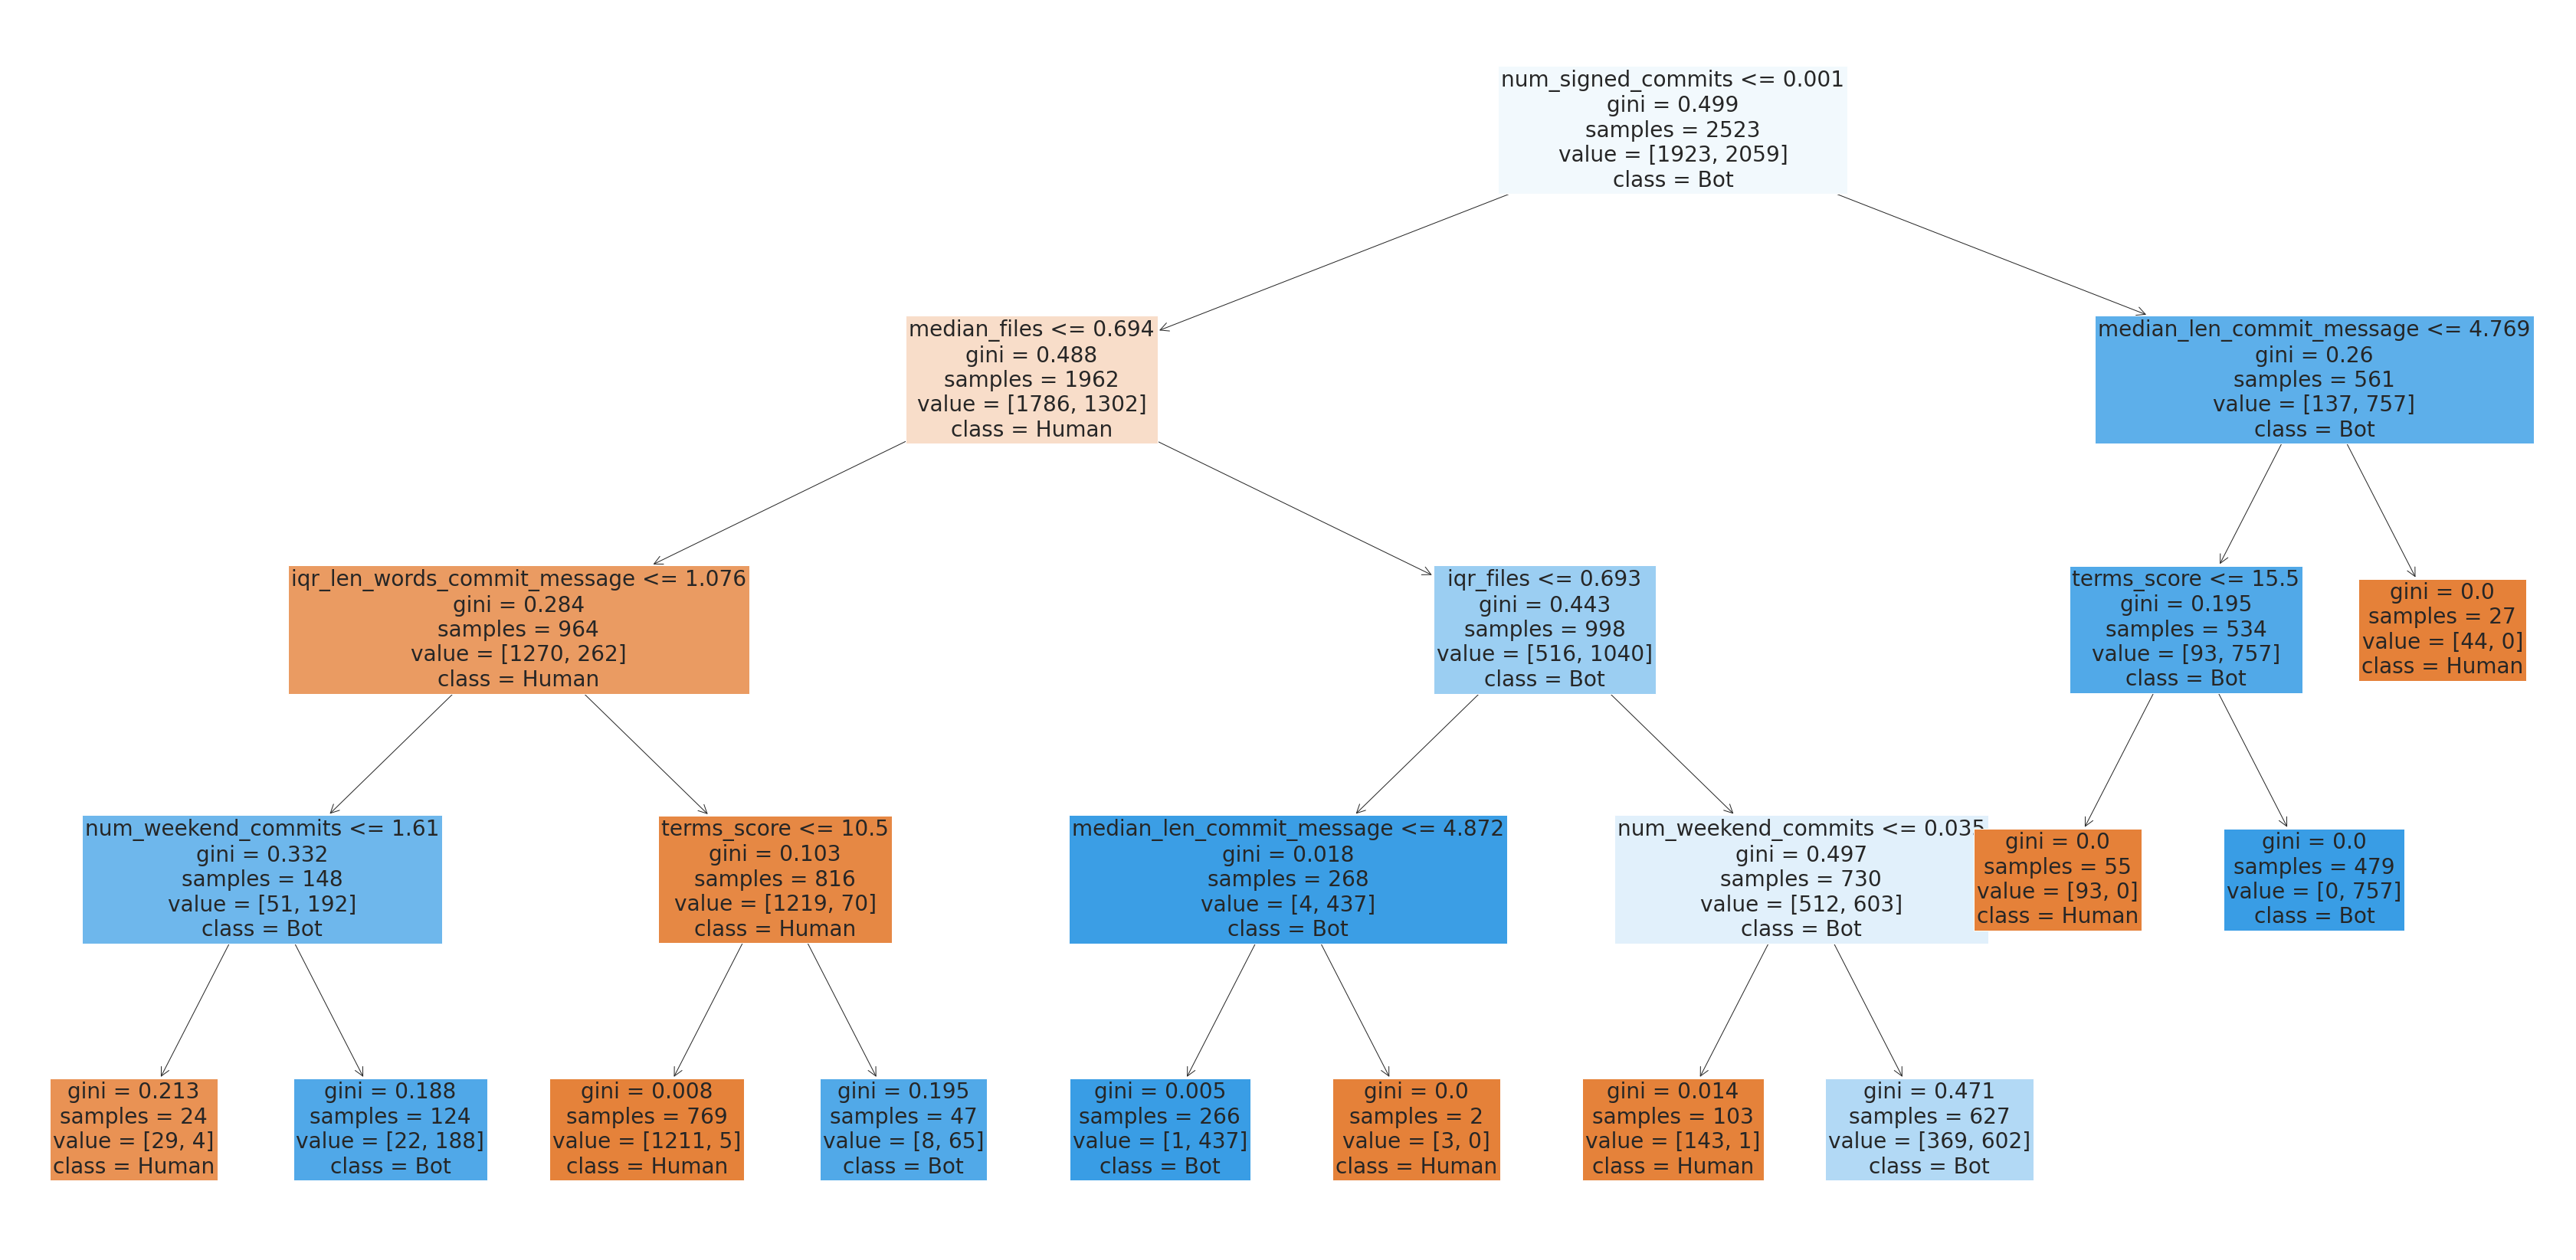

In [23]:
plt.figure(figsize=(60,30))
tree.plot_tree(rf_adj[23], feature_names=list_cols,  
               class_names=['Human', 'Bot'],
               filled=True, fontsize=28)
plt.show()

### XGBoost Classifier

XGBoost is an ensemble model which uses decision trees as base learners. XGBoost uses CART trees (Classification and Regression trees), with scores on whether an observation belongs to a class or not. When this process reaches the max depth of the tree, the algorithm converts the scores into categories assigning a threshold value.

[21:26:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


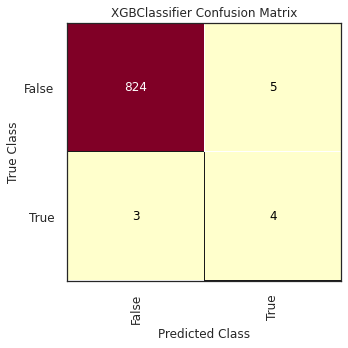

,Score
F2-score,0.541
Precision,0.444
Recall,0.571


In [24]:
xgb_adj = xgb.XGBClassifier(n_estimators=150, max_depth=4, booster='gbtree', objective='binary:logistic', seed=22);
xgb_adj.fit(X_train_git_SMOTE, y_train_git_SMOTE);

y_pred_xgb_adj = xgb_adj.predict(X_test_git);

precision, recall, f2_score = print_model_report(xgb_adj, X_train_git_SMOTE, y_train_git_SMOTE, X_test_git, y_test_git)
results = [precision, recall, f2_score]
df_scores = add_score_to_df(df_scores, 'XGBoost', 'Test', results)

# Show prettified results
score_dict = {'Score':{'Precision': precision,
                       'Recall': recall,
                       'F2-score': f2_score}}
pd.DataFrame.from_dict(score_dict)

## Models Evaluation 

The results from the tested classifiers are summarized in the following table:

In [25]:
df_scores

,model_subset,model_name,precision_score,recall_score,f2_score
0,Test,Gaussian Naive-Bayes,0.136,0.857,0.417
1,Test,LinearSVC,0.143,0.857,0.429
2,Test,KNN,0.316,0.857,0.638
3,Test,Decision Tree,0.385,0.714,0.61
4,Test,Random Forest,0.667,0.857,0.811
5,Test,XGBoost,0.444,0.571,0.541


The classification model with the best results was the **Random Forest Classifier**. These results were also tested using a 5-fold cross validation.

The parameters that worked best for the Random Forest Classifier were:
* Number of estimators (Trees in the forest): 300.
* Split criterion: Gini impurity.
* Maximum depth: 4 levels.


##### K-fold cross validation

In [26]:
# Define K-Fold Cross Validation
cv = KFold(n_splits=5, random_state=22, shuffle=True)

# Define scoring function

f_two_scorer = make_scorer(fbeta_score, beta=2)

scoring_dict = {
    'f2_score': f_two_scorer
}

# Evaluate model
scores = cross_validate(rf_adj, X_train_git_SMOTE, y_train_git_SMOTE, scoring=scoring_dict, cv=cv, n_jobs=-1, return_train_score=True)

# Report Performance
kfold_df = pd.DataFrame.from_dict(scores)
kfold_df.index.name = 'Fold'
kfold_df

,fit_time,score_time,test_f2_score,train_f2_score
Fold,,,,
0,2.003391,0.072061,0.957225,0.962070
1,1.636676,0.075003,0.966533,0.959000
2,1.591288,0.073190,0.956435,0.962686
3,1.955630,0.071822,0.954774,0.962465
4,1.587307,0.078099,0.968069,0.966275


## Validate results: Randon Forest Classifier

The classification model with the best results was the Random Forest Classifier, with **F-beta = 0.811** using the **Test dataset**. According to the results, 6 out of 7 bot accounts were properly classified, and 826 human accounts out of 829. 

Next step is to validate the chosen classifier with the **Validation dataset**.

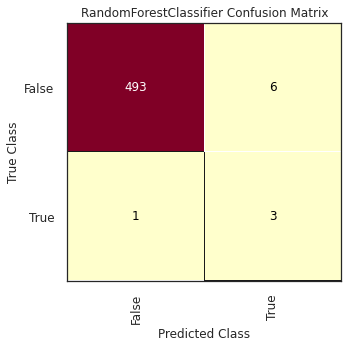

,Score
F2-score,0.600
Precision,0.333
Recall,0.750


In [27]:
X_val_git = preprocess_git_df(X_val_git_og)

y_pred_rf_adj_val = rf_adj.predict(X_val_git)

precision, recall, f2_score = print_model_report(rf_adj, X_train_git_SMOTE, y_train_git_SMOTE, X_val_git, y_val_git)
results = [precision, recall, f2_score]
df_scores = add_score_to_df(df_scores, 'Random Forest', 'Validation', results)

# Show prettified results
score_dict = {'Score':{'Precision': precision,
                       'Recall': recall,
                       'F2-score': f2_score}}
pd.DataFrame.from_dict(score_dict)

#### Precision-Recall Curve

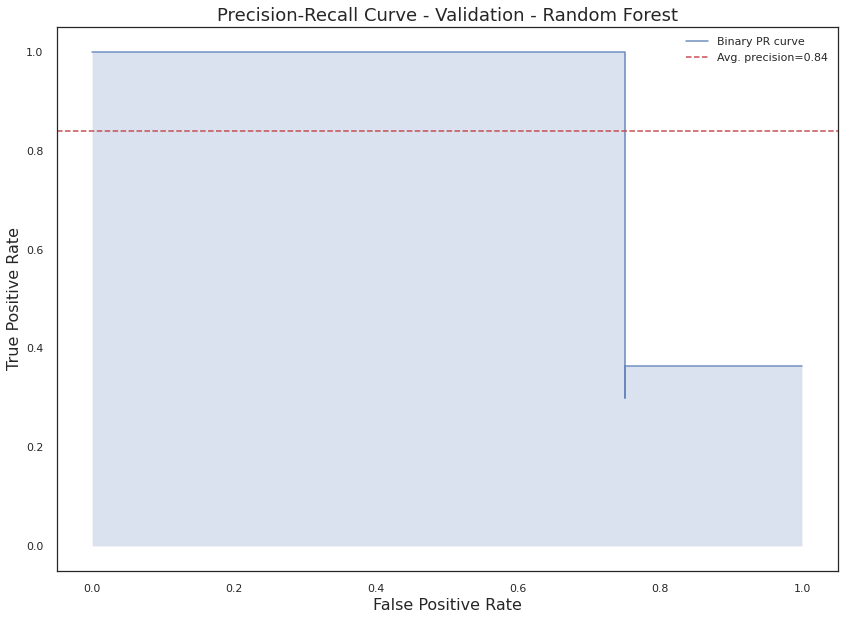

In [28]:
plt.figure()
plt.title("Precision-Recall Curve - Validation - Random Forest", fontsize=18)
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)

visualizer = PrecisionRecallCurve(rf_adj, classes=["Human", "Bot"])
visualizer.fit(X_train_git_SMOTE, y_train_git_SMOTE)
visualizer.score(X_val_git, y_val_git)

plt.legend();

#### Feature importance

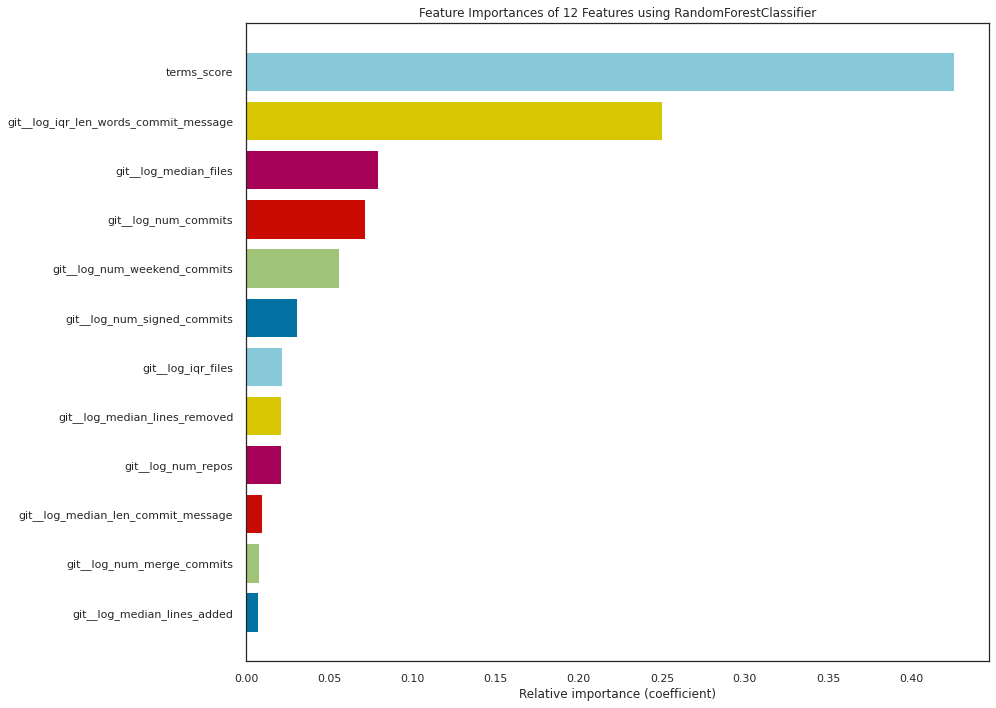

In [29]:
viz = FeatureImportances(rf_adj, xlabel='Relative importance (coefficient)', relative=False, colormap='yellowbrick')
viz.fit(X_val_git, y_val_git)
viz.show();

## Conclusion

When trying these results with the **Validation dataset**, the obtained score was **F-beta = 0.6**. Given that there were only 4 occurrences of bot accounts, three of them were classified correctly and only one was not. Regarding the human accounts, 493 out of 499 accounts were classified accurately.

Looking at the feature importances obtained from our chosen classifier, it is clear that the terms score variable we produced was the most relevant for deciding the classes, followed by the logarithmic transformation of the interquartilic range of the number of words in the commit messages, with a relative importance of 60%. Then, the logarithmic transformation of the median number of files and the number of commits have a relative importance of around 20%, while the rest of the variables are barely significant for the classification.

In [30]:
%%javascript
 IPython.OutputArea.prototype._should_scroll = function(lines) {
     return false;
 }

<IPython.core.display.Javascript object>